In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import registration as rg

from registration.utils import create_nifti_image, loadNiiImages
from registration.utils import getMutualInformation

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [20]:
deformation = np.load("reg/deformation3d.npy")

In [14]:
deformation = np.transpose(deformation, [1,2,3,0])

In [15]:
deformation.shape

(528, 320, 456, 3)

In [16]:
grad_u = np.gradient(deformation[..., 0])  # Gradient of the x-component (u)
grad_v = np.gradient(deformation[..., 1])  # Gradient of the y-component (v)
grad_w = np.gradient(deformation[..., 2])  # Gradient of the z-component (w)


In [17]:
jacobian_matrices = np.zeros((deformation.shape[0], deformation.shape[1], deformation.shape[2], 3, 3))


jacobian_matrices[..., 0, 0], jacobian_matrices[..., 0, 1], jacobian_matrices[..., 0, 2] = grad_u
jacobian_matrices[..., 1, 0], jacobian_matrices[..., 1, 1], jacobian_matrices[..., 1, 2] = grad_v
jacobian_matrices[..., 2, 0], jacobian_matrices[..., 2, 1], jacobian_matrices[..., 2, 2] = grad_w

# Compute the determinant of the Jacobian matrix at each point
det_jacobian = np.linalg.det(jacobian_matrices)

In [3]:
templateImagePath = "../CCF_DATA/average_template_25.nii.gz"
dataImagePath = "brain_25.nii.gz"
annotationImagePath = "../CCF_DATA/annotation_25.nii.gz"

fixedImagePath = templateImagePath
movingImagePath = dataImagePath

In [4]:
import os
outputDir = "reg"
if not os.path.isdir(outputDir):
    os.mkdir(outputDir)
    
if not os.path.isdir("reg/tests"):
    os.mkdir("reg/tests")

In [5]:
A, axisAlignedData = rg.axisAlignData([fixedImagePath, movingImagePath])

axisAlignedDataPath  = os.path.join(outputDir , "axisAlignedData.nii.gz")

TypeError: axisAlignData() missing 1 required positional argument: 'movingImage'

In [ ]:
create_nifti_image(axisAlignedData, 2.5, axisAlignedDataPath, 1)

# Elastix

In [ ]:
elastixResult  = rg.elastixRegistration(fixedImagePath , axisAlignedDataPath, outputDir, rescale=True)
elastixResult  = rg.elastixTransformation(axisAlignedDataPath, outputDir)

# Elastix Refined

In [ ]:
deformationField  = rg.sliceToSlice3DLaplacian(fixedImagePath , elastixResult , axis =0 )

In [ ]:
transformedData   = rg.applyDeformationField(elastixResult , deformationField)
refinedResultPath = os.path.join(outputDir, "elastixRefined.nii.gz")
create_nifti_image(transformedData, 2.5, refinedResultPath, 1/2)
np.save(os.path.join(outputDir,"deformation3d.npy"), deformationField)

# Ants

In [ ]:
import ants

antsResult = os.path.join(outputDir, 'ants.nii')
fixed_image = ants.image_read(fixedImagePath)
moving_image = ants.image_read(dataImagePath)
result = ants.registration(fixed_image, moving_image, type_of_transform = 'SyN' )
ants.image_write(result['warpedmovout'], antsResult)

# Ants Refined

In [ ]:
deformationField  = rg.sliceToSlice3DLaplacian(fixedImagePath , antsResult , axis =0 )
transformedData   = rg.applyDeformationField(antsResult , deformationField)
antsRefinedResultPath = os.path.join(outputDir, "antsRefined.nii.gz")
create_nifti_image(transformedData, 2.5, antsRefinedResultPath, 1/2)

In [5]:
antsResult = os.path.join(outputDir, 'ants.nii')



In [6]:
axisAlignedDataPath  = os.path.join(outputDir , "axisAlignedData.nii.gz")


# Ants Refined with Axis align

In [104]:
import ants

antsResult = os.path.join(outputDir, 'ants_a.nii')
fixed_image = ants.image_read(fixedImagePath)
moving_image = ants.image_read(axisAlignedDataPath)
result = ants.registration(fixed_image, moving_image, type_of_transform = 'SyN' )
ants.image_write(result['warpedmovout'], antsResult)

In [106]:
deformationField  = rg.sliceToSlice3DLaplacian(fixedImagePath , antsResult , axis =0 )
transformedData   = rg.applyDeformationField(antsResult , deformationField)
antsRefinedResultPath = os.path.join(outputDir, "antsRefined_a.nii.gz")
create_nifti_image(transformedData, 2.5, antsRefinedResultPath, 1/2)

100%|██████████| 528/528 [10:22<00:00,  1.18s/it]


Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
dx calculated in 256.5954463481903s
dz calculated in 445.34199142456055s


In [107]:
fdata, mdata = loadNiiImages([fixedImagePath, antsRefinedResultPath])

print(getMutualInformation(fdata, mdata))

-0.9262215562716178


# Lapalcian 3D with Refined

In [6]:
laplacian3DResult = os.path.join(outputDir, "laplacian3d.nii.gz")

In [7]:
deformationField  = rg.sliceToSlice3DLaplacian(fixedImagePath , laplacian3DResult , axis =0 )
transformedData   = rg.applyDeformationField(laplacian3DResult , deformationField)
refinedResultPath = os.path.join(outputDir, "laplacian3Drefined.nii.gz")
create_nifti_image(transformedData, 2.5, refinedResultPath, 1/2)


fdata, mdata = loadNiiImages([fixedImagePath, refinedResultPath])

print(getMutualInformation(fdata, mdata))

  1%|          | 6/528 [00:01<02:45,  3.16it/s]c:\Users\3i\anaconda3\envs\reg\lib\site-packages\numpy\lib\_function_base_impl.py:4779: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
100%|██████████| 528/528 [10:29<00:00,  1.19s/it]


Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
dx calculated in 257.5960006713867s
dz calculated in 426.78000044822693s
-0.7402206109213697


# Plots

In [7]:
import nibabel as nib

In [8]:
annotationImagePath = "../CCF_DATA/annotation_25.nii.gz"
annotationImage = nib.load(annotationImagePath)
annData = annotationImage.get_fdata()

In [9]:
from skimage.color import gray2rgb, label2rgb
from skimage.segmentation import mark_boundaries, find_boundaries
from skimage import feature
from skimage import measure
import skimage
def convertToUint8(data):
    """
    Thresholds  and converts data to UINT8
    """
    maxVal  = np.percentile(data, 99)
    data[data > maxVal ] = maxVal
    data = data*255 /maxVal
    data = data.astype(np.uint8)
    
    return data

def drawContours(image, contours):
    if( len(np.squeeze(image).shape) ==2): 
        image  = gray2rgb (image)
    
    result_image = label2rgb(contours, image, alpha=0.5)
    return skimage.img_as_ubyte(result_image)

def getEdgeContours(image):
    """
    Applies Otsu Threshold and gets both outer and internal contours. 
    Filters by contour length
    """
    
    image[image>500]=500
    #data = skimage.exposure.equalize_adapthist(image.astype(np.uint16))*255
    local_thresh = skimage.filters.threshold_otsu(image)
    binary = image>local_thresh

    edges = feature.canny(binary, sigma=1)
    all_labels = measure.label(edges)
    
    for label in range(np.max(all_labels)):
        # Edge Length Paramenter should be automated
        if( np.sum(all_labels==label)<100):
            edges[all_labels==label] = 0

    edges = skimage.morphology.thin(edges)
    return edges, binary

def getAnnContours(image):
    """
    Applies Otsu Threshold and gets both outer and internal contours. 
    Filters by contour length
    """
    image[image<1] =0
    edges = feature.canny(image, sigma=1)
    all_labels = measure.label(edges)
    
    for label in range(np.max(all_labels)):
        # Edge Length Paramenter should be automated
        if( np.sum(all_labels==label)<100):
            edges[all_labels==label] = 0

    edges = skimage.morphology.thin(edges)
    return edges


def labelWithAnnotation(data, annotation):
    e = find_boundaries(annotation)
    contouredImage = drawContours(data, e)
    return contouredImage
    
def getTestSamples(data, template= None, n=8,  testSamples=[],axis =0 , saveprefix="",):
    """
    Draws Contours extracted from moving onto fixed samples
    """
    assert n>1
    if type(data) == str:
        dataImage = nib.load(data)
        data = dataImage.get_fdata()
    data[data<0] =0
    data = convertToUint8(data)
    labelled_samples =[] 
    if len(testSamples)==0:
        testSamples = np.arange(0, data.shape[0], data.shape[0]/n)[1:]
        testSamples = testSamples.astype(int)
    if template is None:
        for testSample in testSamples:
            labelled_samples.append(data[testSample] )
            if saveprefix != "":
                skimage.io.imsave("tests/{}_{}.jpg".format(saveprefix, testSample),data[testSample] )
        return labelled_samples
    if type(template) == str:
        templateImage = nib.load(template)
        template = templateImage.get_fdata()
        template = convertToUint8(template)
    labelled_samples =[]    
    for testSample in testSamples:
        contouredImage  = labelWithAnnotation(np.take(data, testSample, axis=axis),np.take(template, testSample, axis=axis))
        labelled_samples.append(contouredImage)
        
        if saveprefix != "":
            skimage.io.imsave("tests/{}_{}.jpg".format(saveprefix, testSample),contouredImage )
    return labelled_samples

In [10]:
import os

In [11]:
imDir = "imdir"
os.makedirs(imDir, exist_ok=True)

In [12]:
axis0testSamples = [229, 407, 457]
axis1testSamples = [173, 173]

In [13]:
outputDir = 'reg'

In [14]:
basicSampleDir = os.path.join(imDir, "ants")
imagePath= os.path.join(outputDir, "ants.nii")

ants_samples_0= getTestSamples(imagePath, annData , axis =0 , testSamples=axis0testSamples)
ants_samples_1= getTestSamples(imagePath, annData , axis =1 , testSamples=axis1testSamples)

if not os.path.isdir(basicSampleDir):
    os.mkdir(basicSampleDir)

for i, sample in enumerate(ants_samples_0):
    skimage.io.imsave(os.path.join(basicSampleDir, "axis0_{}.jpg".format( axis0testSamples[i])),ants_samples_0[i] )

for i, sample in enumerate(ants_samples_1):
    skimage.io.imsave(os.path.join(basicSampleDir, "axis1_{}.jpg".format( axis1testSamples[i])),ants_samples_1[i] )

In [15]:
basicSampleDir = os.path.join(imDir, "antsRefined")
imagePath= os.path.join(outputDir, "antsRefined_a.nii.gz")
ants_refined_samples_0 = getTestSamples(imagePath, annData , axis =0 , testSamples=axis0testSamples)
ants_refined_samples_1 = getTestSamples(imagePath, annData , axis =1 , testSamples=axis1testSamples)

if not os.path.isdir(basicSampleDir):
    os.mkdir(basicSampleDir)

for i, sample in enumerate(ants_samples_0):
    skimage.io.imsave(os.path.join(basicSampleDir, "axis0_{}.jpg".format( axis0testSamples[i])),ants_refined_samples_0[i] )

for i, sample in enumerate(ants_samples_1):
    skimage.io.imsave(os.path.join(basicSampleDir, "axis1_{}.jpg".format( axis1testSamples[i])),ants_refined_samples_1[i] )

In [16]:
fdata, antsRefined_no_overlay = loadNiiImages([fixedImagePath, imagePath])

In [17]:
antsRefined_no_overlay[antsRefined_no_overlay<0] = 0

antsRefined_no_overlay = convertToUint8(antsRefined_no_overlay)

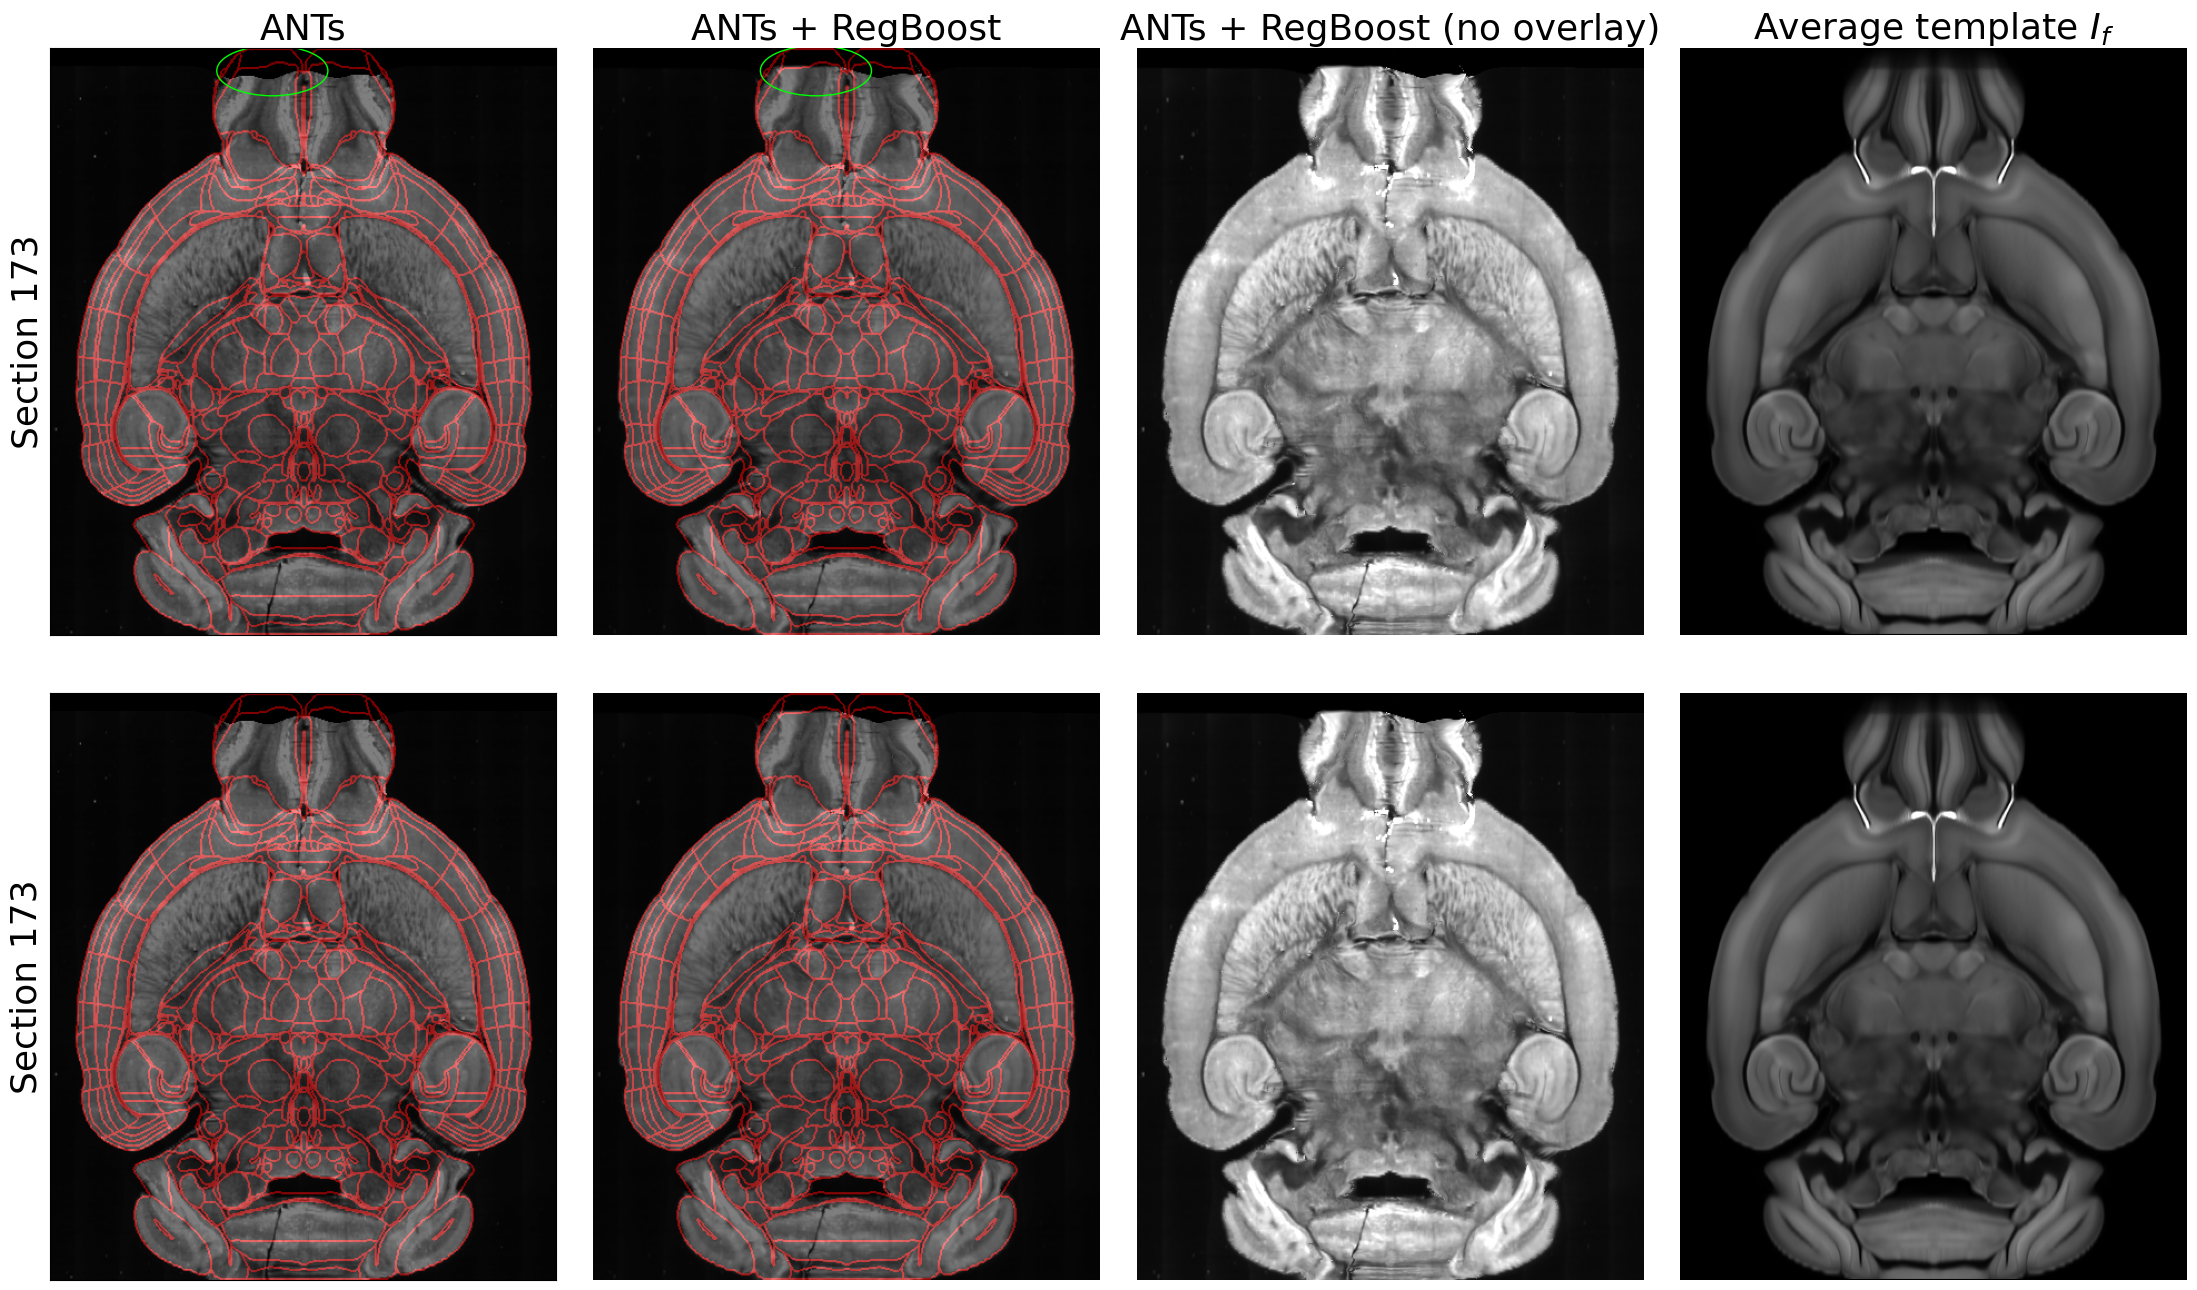

In [19]:
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 4, figsize=(40, 16))
for i,sno in enumerate(axis1testSamples):
    ax[i][0].imshow(ants_samples_1[i])
    #ax[i][1].imshow(rescaledSamples_1[i])
    ax[i][1].imshow(ants_refined_samples_1[i])
    ax[i][2].imshow(antsRefined_no_overlay[:, sno, :], cmap='gray')
    ax[i][3].imshow(np.take(fdata, sno, axis=1), cmap='gray')
    if i ==0 :
        ax[0][0].set_title('ANTs', fontsize=26)
        #ax[0][1].set_title('elastix after rotation correction', fontsize=26)
        ax[0][1].set_title('ANTs + RegBoost', fontsize=26)
        ax[0][2].set_title('ANTs + RegBoost (no overlay)', fontsize=26)
        ax[0][3].set_title('Average template $I_f$', fontsize=26)
    ax[i][0].set_xticks([])
    ax[i][0].set_yticks([])
    for j in range(1, 4):
        ax[i][j].axis(False)
    ax[i][0].set_aspect('equal')
    ax[i][0].set_ylabel("Section {}".format(sno), fontsize=26)
    
##########################################################################################
    

# Top middle
point = (200, 20)
width = 100
height = 45
angle = 0

ellipse = Ellipse(xy=point, width=width, height=height, 
                  edgecolor='#00FF00', fc='None', lw=1, angle=angle)
ax[0, 0].add_patch(ellipse)
ellipse = Ellipse(xy=point, width=width, height=height, 
                  edgecolor='#00FF00', fc='None', lw=1, angle=angle)
ax[0, 1].add_patch(ellipse)


plt.subplots_adjust(wspace=-0.63, hspace=0.1)
plt.savefig(os.path.join(imDir, "combined_ants1.png"))
plt.show()

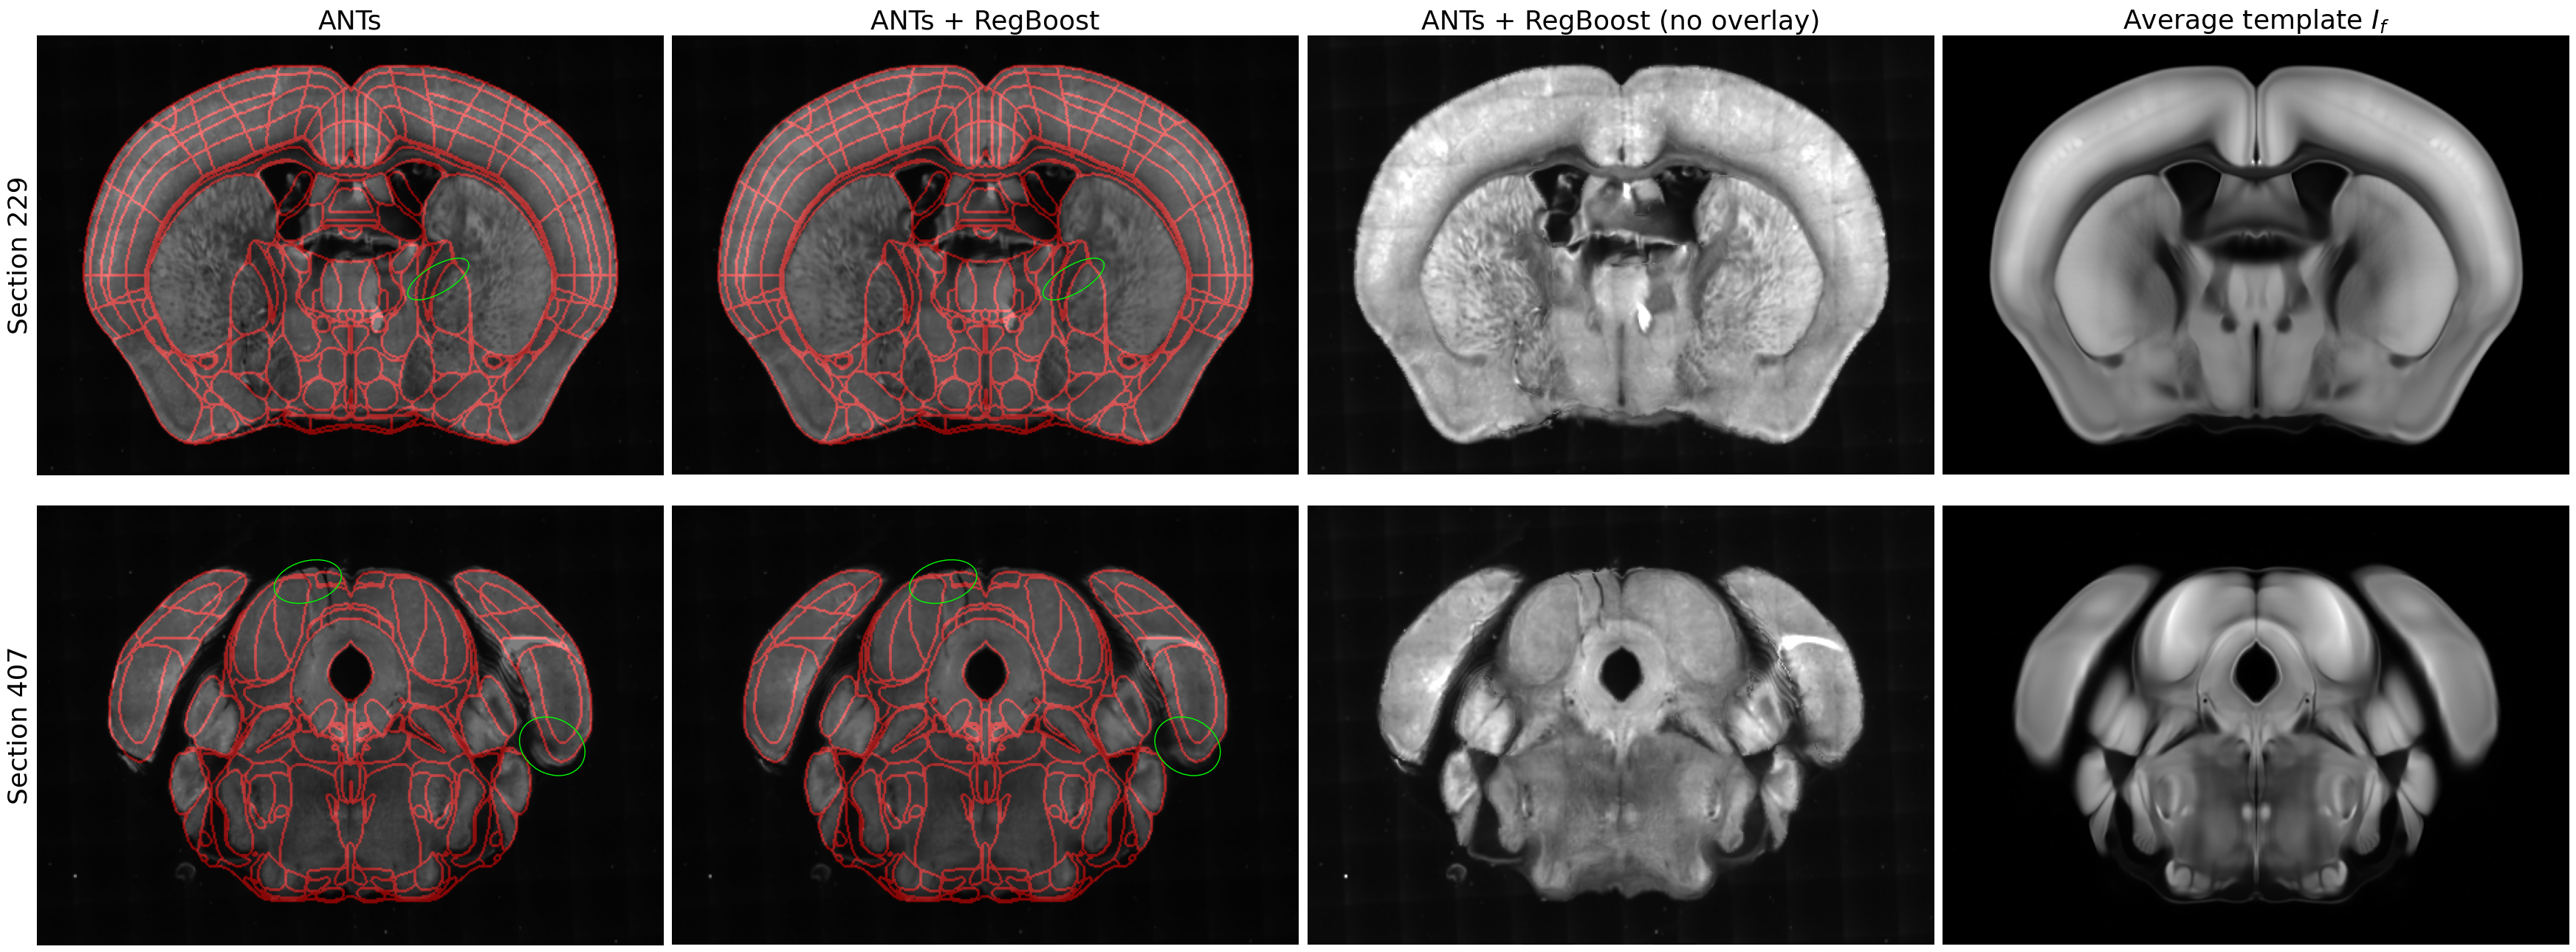

In [20]:
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 4, figsize=(45, 16))

j = 0

for i,sno in enumerate(axis0testSamples):
    if sno in [229, 407]:
        ax[j][0].imshow(ants_samples_0[i])
        #ax[j][1].imshow(rescaledSamples_0[i])
        ax[j][1].imshow(ants_refined_samples_0[i])
        #ax[j][2].imshow(refinedSamples_0[i])
        ax[j][2].imshow(antsRefined_no_overlay[sno], cmap='gray')
        ax[j][3].imshow(np.take(fdata, sno, axis=0), cmap='gray')
        ax[j][0].set_xticks([])
        ax[j][0].set_yticks([])
        ax[0][0].set_title('ANTs', fontsize=26)
        #ax[0][1].set_title('elastix after rotation correction', fontsize=26)
        ax[0][1].set_title('ANTs + RegBoost', fontsize=26)
        ax[0][2].set_title('ANTs + RegBoost (no overlay)', fontsize=26)
        ax[0][3].set_title('Average template $I_f$', fontsize=26)
        for k in range(1, 4):
            ax[j][k].axis(False)
        ax[j][2].set_aspect('equal')
        ax[j][0].set_ylabel("Section {}".format(sno), fontsize=26)
        j += 1
        
#########################################################################################
        



# C
point = (292, 177)
width = 50
height = 20
angle = -30

ellipse = Ellipse(xy=point, width=width, height=height, 
                  edgecolor='#00FF00', fc='None', lw=1, angle=angle)
ax[0, 0].add_patch(ellipse)
ellipse = Ellipse(xy=point, width=width, height=height, 
                  edgecolor='#00FF00', fc='None', lw=1, angle=angle)
ax[0, 1].add_patch(ellipse)

    
#######################################################################################
    
point_a = (160, 10)
point_b = (290, 48)
point_c = (120, 70)
point_d = (25, 200)
point_e = (242, 237)


# Top border
point = (197, 55)
width = 50
height = 30
angle = -15

ellipse = Ellipse(xy=point, width=width, height=height, 
                  edgecolor='#00FF00', fc='None', lw=1, angle=angle)
ax[1, 0].add_patch(ellipse)
ellipse = Ellipse(xy=point, width=width, height=height, 
                  edgecolor='#00FF00', fc='None', lw=1, angle=angle)
ax[1, 1].add_patch(ellipse)

# Bottom middle circle
point = (375, 175)
width = 50
height = 40
angle = 30

ellipse = Ellipse(xy=point, width=width, height=height, 
                  edgecolor='#00FF00', fc='None', lw=1, angle=angle)
ax[1, 0].add_patch(ellipse)
ellipse = Ellipse(xy=point, width=width, height=height, 
                  edgecolor='#00FF00', fc='None', lw=1, angle=angle)
ax[1, 1].add_patch(ellipse)

  
########################################################################################
plt.subplots_adjust(wspace=-0.05, hspace=0.07)
plt.savefig(os.path.join(imDir, "combined_ants0.png"))
plt.show()

# SynthMorph Data

Use the fixedr.nii.gz and movingr.nii.gz images with synthmorph docker to register.


In [5]:
refImagePath = '../../voxelmorph/data/ref.nii.gz'
import nibabel as nib
def save_ref(array, filename):
    affine = np.array([[-1, 0, 0, 0],  # nopep8
                        [0, 0, 1, 0],  # nopep8
                        [0, -1, 0, 0],  # nopep8
                        [0, 0, 0, 1]], dtype=float)  # nopep8


    pcrs = np.append(np.array(array.shape[:3]) / 2, 1)
    affine[:3, 3] = -np.matmul(affine, pcrs)[:3]
    nib.save(nib.Nifti1Image(array, affine), filename)
    

In [6]:
def rescaleTo0_1(data):
    """
    Thresholds  and converts data to UINT8
    """
    maxVal  = np.percentile(data, 99)
    data[data > maxVal ] = maxVal
    data = data /maxVal
    return data

In [7]:
import scipy

ref, data, fixed = loadNiiImages([refImagePath, movingImagePath, fixedImagePath], scale = False)
data = data.transpose(2,0,1)
fixed = fixed.transpose(2,0,1)
data = rescaleTo0_1(data)
fixed = rescaleTo0_1(fixed)

scales = tuple(np.array(ref.shape)/np.array(data.shape))
imdata =  scipy.ndimage.zoom(data.copy(), scales, order=1)
save_ref(imdata, 'movingr.nii.gz')

scales = tuple(np.array(ref.shape)/np.array(fixed.shape))
imdata =  scipy.ndimage.zoom(fixed.copy(), scales, order=1)
save_ref(imdata, 'fixedr.nii.gz')


In [8]:
import scipy

In [9]:
ref, moving, fixed = loadNiiImages([refImagePath, movingImagePath, fixedImagePath], scale = False)
moving = moving.transpose(2,0,1)
scales = tuple(np.array(ref.shape)/np.array(moving.shape))
imdata =  scipy.ndimage.zoom(moving.copy(), scales, order=1)
save_ref(imdata, 'movingr_.nii.gz')

Run these steps for synth morph result
``` 
docker run --rm -v /test:/mnt -it --entrypoint bash freesurfer/synthmorph
```
Copy files into docker container

```
mri_synthmorph -o /mnt/test.nii /mnt/movingr.nii.gz /mnt/fixedr.nii.gz
```

In [10]:
import scipy

refImagePath = '../../voxelmorph/data/ref.nii.gz'

synthResultPath = 'test.nii'
transformImagePath = 'transform.nii'
transform, annData, synthResult, moving= loadNiiImages([transformImagePath, annotationImagePath, synthResultPath, 'movingr_.nii.gz'], scale = False)
ann = annData.transpose(2,0,1)

scales = tuple(np.array(ann.shape)/np.array(synthResult.shape))
synth =  scipy.ndimage.zoom(synthResult.copy(), scales, order=1)
synth = synth.transpose(1,2,0)


scales = tuple(np.array(ann.shape)/np.array(moving.shape))
moving =  scipy.ndimage.zoom(moving.copy(), scales, order=1)
moving = moving.transpose(1,2,0)


scales = tuple(np.array(ann.shape)/np.array(transform.shape[:3]))
scales = (scales[0], scales[1], scales[2], 1)
transform =  scipy.ndimage.zoom(transform.copy(), scales, order=1)
transform = transform.transpose(3, 1,2,0)

In [ ]:
moving.shape

(562, 280, 436)

In [11]:
synthTransformedData   = rg.applyDeformationField(moving , transform)

: 

In [12]:
fdata, mdata = loadNiiImages([fixedImagePath, synthTransformedData])

print(getMutualInformation(fdata, mdata))

-0.29141733754413707


In [13]:
from registration.plot_utils import plot_samples

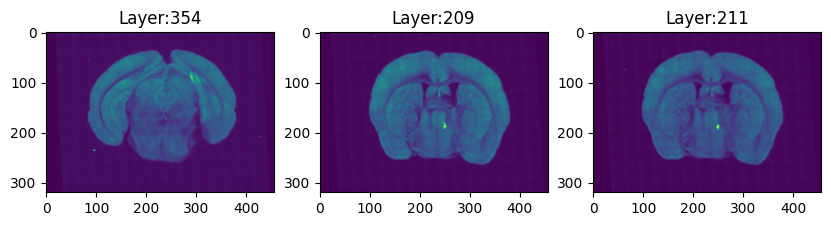

In [14]:
plot_samples(synthTransformedData)

In [15]:
deformationField  = rg.sliceToSlice3DLaplacian(fixedImagePath , synthTransformedData , axis =0 )
transformedData   = rg.applyDeformationField(synthTransformedData , deformationField)
refinedResultPath = os.path.join(outputDir, "synthRefined.nii.gz")
create_nifti_image(transformedData, 2.5, refinedResultPath, 1/2)


fdata, mdata = loadNiiImages([fixedImagePath, refinedResultPath])

print(getMutualInformation(fdata, mdata))

100%|██████████| 528/528 [09:27<00:00,  1.07s/it]


Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
dx calculated in 311.60021018981934s
dz calculated in 587.5526785850525s
-0.4395451487205062


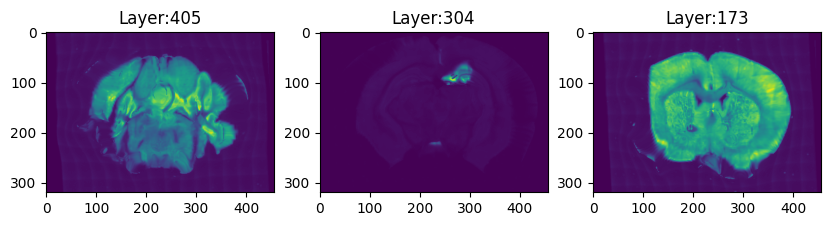

In [17]:
plot_samples(transformedData)

In [12]:
deformationField  = rg.reg3D(fixedImagePath , synthTransformedData, 25, 5, 75)
transformedData   = rg.applyDeformationField(synthTransformedData , deformationField)
refinedResultPath = os.path.join(outputDir, "synthRefined_.nii.gz")
create_nifti_image(transformedData, 2.5, refinedResultPath, 1/2)


fdata, mdata = loadNiiImages([fixedImagePath, refinedResultPath])

print(getMutualInformation(fdata, mdata))

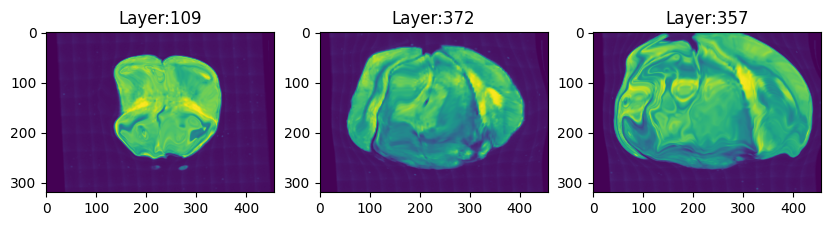

In [91]:
plot_samples(transformedData)

In [ ]:
movingImagePath

In [90]:
synth = synth * 255
moving = moving * 255

In [91]:
synth_sample= getTestSamples(synth, annData , axis =0 , testSamples=[255])

synth_moving= getTestSamples(moving, annData , axis =0 , testSamples=[255])

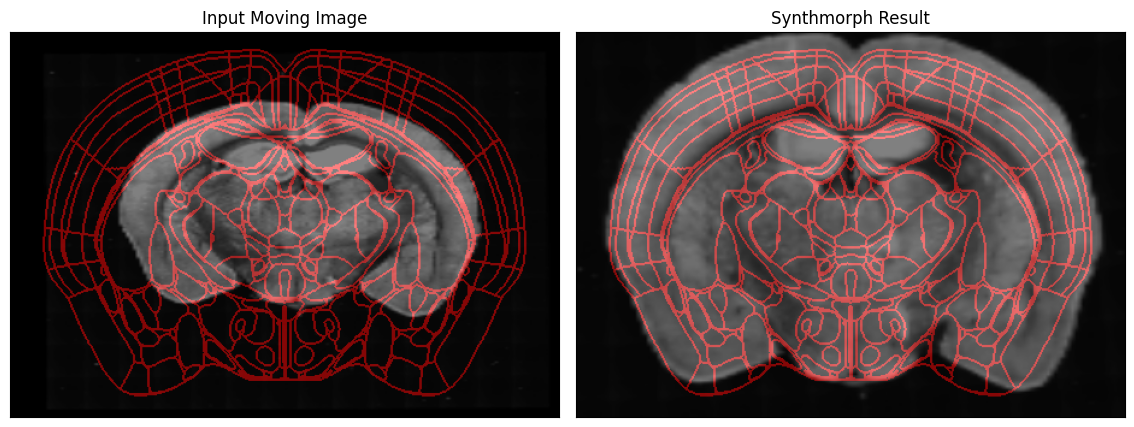

In [102]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(synth_moving[0])
ax[1].imshow(synth_sample[0])
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[0].set_title('Input Moving Image')
ax[1].set_title('Synthmorph Result')
plt.subplots_adjust(wspace=-0.05, hspace=0.07)
plt.savefig(imDir + '/synth.png')


In [ ]:
fixed_image = ants.image_read('CCF_DATA/average_template_25.nii.gz')

In [31]:
fdata, mdata = loadNiiImages([fixedImagePath, elastixResult])
print(getMutualInformation(fdata, mdata))


-0.7371502453912386


In [32]:
fdata, mdata = loadNiiImages([fixedImagePath, refinedResultPath])

print(getMutualInformation(fdata, mdata))


-0.8205656826524651


In [40]:
fdata, mdata = loadNiiImages([fixedImagePath, antsResult])

print(getMutualInformation(fdata, mdata))


-0.894353050669145


In [41]:
fdata, mdata = loadNiiImages([fixedImagePath, antsRefinedResultPath])

print(getMutualInformation(fdata, mdata))

-0.8932840748970851
